# Mapping inundation according to flow rates <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers),
[BoM Water Data Online](http://www.bom.gov.au/waterdata/)

## Background
Many of Australia's water bodies are regulated by humans. 
Flows are controlled by regulatory bodies such as the Murray Darling Basin Authority and local governments to meet the needs of water users while maintaining ecosystems dependant on the surface water. 
It is important that regulators know where the water goes when it goes overbank to help manage wetland inundations for environmental purposes and be informed of rural or residential areas likely to be flooded as a result of a large dam release. 

Gauges have been placed along river systems all over Australia to monitor flow rates and water levels, however tracking where water goes when it spills over bank at a certain rate is challenging without combining the gauge data with satellite data.  

### Digital Earth Australia use case 
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs) dataset detects surface water in Australia based on Landsat data. 
By linking this dataset with gauge data, we can get information on where the water goes when it goes overbank according to flow rates measured by the gauge. 
Being able to see where water goes at different flow rates is valuable information for water regulators. 

## Description
In this example, we take gauge data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/) webpage and link it to WOfS data to create a summary image of water frequency according to a user-specified flow rate. 
The worked example demonstrates how to:

1. Generate a Flow Duration Curve from stream gauge data
2. Use Dask loading to link the WOfS dataset to the stream gauge data
3. Call WOfS data by flow rate as opposed to chronological time range
4. Cloud mask WOfS data
5. Generate a frequency image of water from the WOfS data

***

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages
Load key Python packages and supporting functions for the analysis. This notebook relies on a module called `dea_bom`, which is located in the `Scripts` directory. 

In [1]:
%matplotlib inline

import os
import sys
import pickle
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display
from datacube.storage import masking
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

sys.path.append('../Scripts')
import dea_bom


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Inundation_mapping')

## Retrieve stream gauge data


This box retrieves data from the Bureau of Meteorology (BOM) [Water Data Online](http://www.bom.gov.au/waterdata/) webpage using the `dea_bom` module.
We restrict the list of gauges to locations that we have identified as having valid data.

In [3]:
stations_pkl = Path('../Supplementary_data/Inundation_mapping/stations.pkl')

# If cache exists, get station data from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))

# Filter list to stations with available data
stations_with_data = pickle.load(open(str('../Supplementary_data/Inundation_mapping/stations_with_data.pkl'), 'rb'))
stations = [i for i in stations if i.name in stations_with_data]

# Preview the first five stations loaded
print(f'{len(stations)} stations loaded; e.g.:')
stations[:5]

Loading from cache
4299 stations loaded; e.g.:


[namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
 namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
 namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
 namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318'),
 namespace(name='18 Mile Swamp HorseX', pos=(-27.49561971, 153.50836409), url='http://bom.gov.au/waterdata/services/stations/144005A')]

## Plot a map of stations and select a gauge that contains data

Running this cell will generate a map displaying the locations of stream gauges in Australia. It will take about 20 seconds to load. Choose a gauge on the map by clicking on it. Note that after you click on a gauge it can take a second or two to respond. 

When you have the station you want, **click the Done button before moving onto the next box**. If you want to choose a different gauge after having pressed the `Done` button, you must re-run this box to regenerate the map then choose another gauge and press `Done` again. 

> **Note:** If all gauges you click on return "0 observations", this could indicate an issue with fetching data from the BOM webpage. In this case, re-start the notebook and try again later

In [5]:
gauge_data, station = dea_bom.ui_select_station(stations,
                                                zoom=10,
                                                center=(-34.72, 143.17));


## Generate a flow duration curve from the data selected above
A flow duration curve is a way of displaying flow rate data that is often used by hydrologists to characterise a river. 
Flows for each day are ranked from highest to lowest flow on the y-axis. 
The x-axis is "exceedence", which means "the percentage of the time the river was at that flow or higher", with the formula for the x-axis being `1-(rank/number of data points) * 100`. 
A flow duration curve is useful for this application as it allows the user to select satellite data by flow rate rather than by date. 

The code in the box below will automatically select the latitude and longitude of the selected gauge, but you can enter a different `lat` and `lon` if you want by editing the commented out `lat` and `lon` lines in the code below. 
The output will tell you what `lat` and `lon` has been selected. 
The `buffer`, which is the radius around the location point, is set to 8000 meters but you can change it if you like.

> **Note:** If nothing happens when you run this cell, **return to the previous cell and click the Done button**

You have selected: lat = -34.71966901
You have selected: lon = 143.1698626


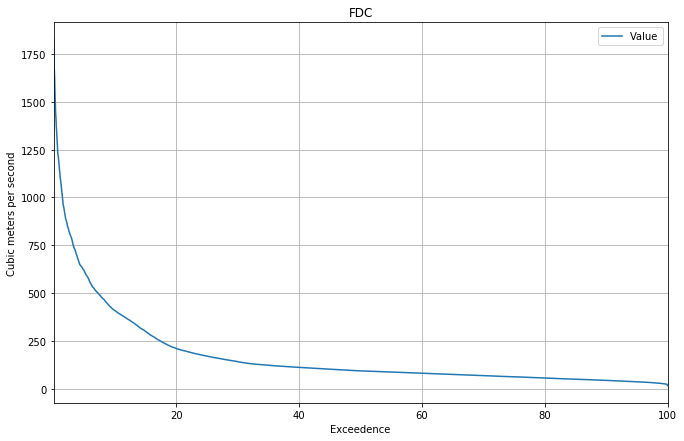

In [6]:
# The lat and lon takes the location of the gauge. You can change the lat 
# and lon to a different location if necessary, just comment out out this 
# lat, lon = pos line below and define your own.
lat, lon = station.pos

# lat =
# lon =

# The buffer is how many meters radius around the location you want to display.
buffer = 8000

# Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1 - (gauge_data.rownumber / len(gauge_data))) * 100

# Plotting the flow duration curve
gauge_data.plot(x='Exceedence', y='Value', figsize=(11, 7))
plt.ylabel('Cubic meters per second')
plt.grid(True)
plt.title('FDC')

print(f'You have selected: lat = {lat}')
print(f'You have selected: lon = {lon}')


## Enter the y-axis parameters in cubic meters per second

In [7]:
# What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 250
yaxis_higher_parameter = 1750

Plotting the flow duration curve on a log scale allows us to better understand the extremeties of the flow rates. 
The next cell displays the selected part of the flow duration curve on a log scale.

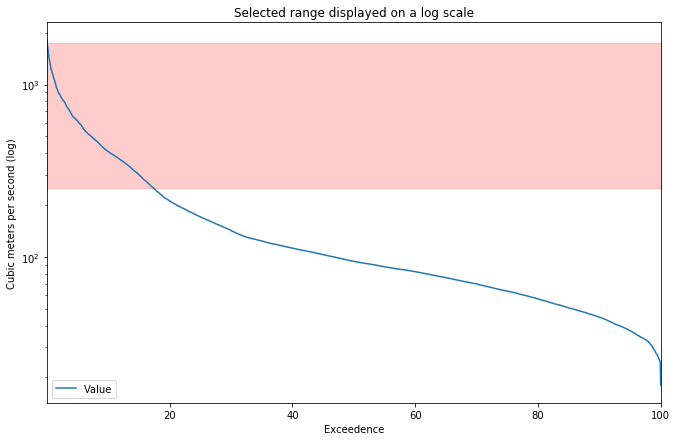

In [8]:
# Plot the data on a log scale
gauge_data.plot(x='Exceedence',
                y='Value',
                logy=True,
                title='Selected range displayed on a log scale',
                figsize=(11, 7))
plt.axhspan(yaxis_lower_parameter,
            yaxis_higher_parameter,
            color='red',
            alpha=0.2)
plt.ylabel('Cubic meters per second (log)');


## Dask loading WOfS data
The next cell uses `Dask` to load only the parameters of the WOfS data without loading the images, which is a faster way to load WOfS data. 
Loading only the parameters is enough to link the WOfS dataset to the dataset from the stream gauge. 
The data are linked by date using `xarray`'s `.interp()` function. 
The code then takes into account the flow rate parameters entered by the user and creates a list of dates where there was a satellite pass while the gauge was reading that value. 
The output tells the user how many passes there were.

In [9]:
# Set up a query which defines the area and time period to load data for
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-10-01'), # Change this date accordingly
         'crs': 'EPSG:3577'} 

# Dask load wofs_albers data (this loads the dataset parameters only, 
# not the actual satellite data)
wofs_albers = dc.load(product = 'wofs_albers', 
                      dask_chunks = {}, 
                      group_by='solar_day', 
                      **query)

# Merging satellite data with gauge data by timestamp
gauge_data_xr = gauge_data.to_xarray()
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time, method='nearest')

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), 
                                    drop=True)

# Get list of dates to keep
date_list = specified_level.time.values

print(f'You are about to load {specified_level.time.shape[0]} satellite passes')

You are about to load 211 satellite passes


## Loading and cloud masking the selected WOfS data
The box below will load the selected WOfS images with `.compute()` and then cloud filter the images, meaning it will take out images that had too much cloud to see anything. 
It does this by using the `.make_mask()` function to calculate the fraction of cloud pixels in each image.
The output will tell you how many passes remain after they were cloud filtered.

In [10]:
# Load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# Calculate the number of cloudy pixels per timestep
cc = masking.make_mask(specified_passes.water, cloud=True)
ncloud_pixels = cc.sum(dim=['x', 'y'])

# Calculate the total number of pixels per timestep
npixels_per_slice = (specified_passes.water.shape[1] * 
                     specified_passes.water.shape[2])

# Calculate the proportion of cloudy pixels
cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)

# Filter out "too cloudy" passes (i.e. more than 50% cloud)
clear_specified_passes = specified_passes.water.isel(
    time=cloud_pixels_fraction < 0.5)

print(f'After cloud filtering, there are '
      f'{clear_specified_passes.time.shape[0]} passes available')

After cloud filtering, there are 181 passes available


## Generating an image of the waterbody based on flow
This cell will generate a water frequency image for the selected location using the passes indicated above. 
One large plot is generated for easy viewing. 
A small plot next to the flow duration curve with the selected parameters is generated to remind the user which part of flow duration curve the images relates to. 

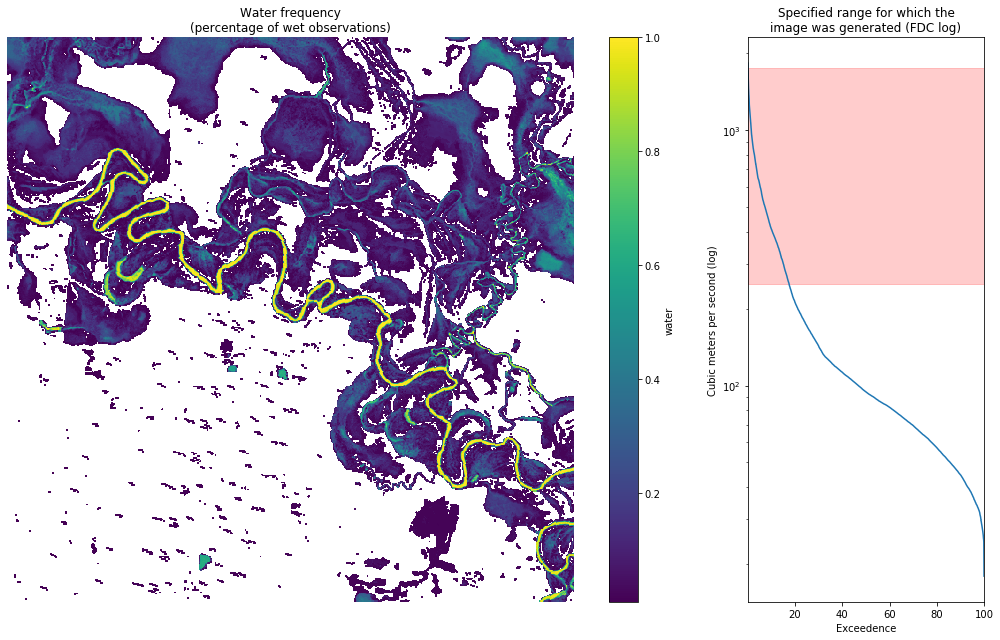

In [11]:
# Identify all wet and dry pixels
wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')

# Calculate how frequently each pixel was wet when it was observed
clear = wet + dry
frequency = wet / clear

# Remove persistent NAs that occur due to mountain shadows
frequency = frequency.fillna(0)  

# Set pixels that remain dry 100% of the time to nodata so they appear white
frequency = frequency.where(frequency != 0)  

# Plotting the image
fig, axes = plt.subplots(nrows=1, 
                         ncols=2, 
                         figsize=(14, 9), 
                         gridspec_kw={'width_ratios': [3, 1]})
frequency.plot(ax=axes[0])
axes[0].set_title('Water frequency\n(percentage of wet observations)')
axes[0].axis('off')

# Plot the gauge data
gauge_data.plot(ax=axes[1], x='Exceedence', y='Value', logy=True, legend=False) 
axes[1].axhspan(ymin=yaxis_lower_parameter, 
                ymax=yaxis_higher_parameter, 
                color='red', 
                alpha=0.2)
axes[1].set_title('Specified range for which the\nimage was generated (FDC log)')
axes[1].set_ylabel('Cubic meters per second (log)')

plt.tight_layout()


## Save the file as a GeoTIFF
You might want to use this water frequency image in another workflow.
The following code will export the image as a `.tif` GeoTIFF file that can be loaded into common GIS software (e.g. ArcMap or QGIS). 

Enter a name for the `.tif` file below. 
The `../` part of the name means it will save this file one directory up from where this notebook is saved, i.e. in your `dea-notebooks` folder.

In [12]:
# Set the output file name 
file_name = '../file_name_here.tif'

# Set up the file for writing
frequency_dataset = frequency.to_dataset()
frequency_dataset.attrs=wofs_albers.attrs

# Write GeoTIFF to a location
write_geotiff(file_name, frequency_dataset)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** December 2019

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.7+142.g7f8581cf


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)